# Template code for CNN

In this notebook, we will show a simple usage of CNN on the MNIST dataset. 
The usage of GPUs is highly recommended

In [1]:
#!pip install torch==2.4 # Run just once
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
from math import floor
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

# Set torch seed


#  Q1

In [2]:
manual_seed = 42
torch.manual_seed(manual_seed)

In [3]:
torch.randint(1, 10 , (1,1))

tensor([[7]])

se runno di fila le due celle ottengo tensor([[7]]) se runni due volte la seconda tensor([[6]])

# Q2


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (1, 1, 1))])

batch_size = 32

dataset_train = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
dataset_test = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False, num_workers=2)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Labels: horse car   plane cat   deer  horse bird  plane cat   truck frog  deer  deer  bird  car   frog  dog   plane car   horse deer  horse horse frog  deer  cat   horse dog   horse cat   ship  frog 


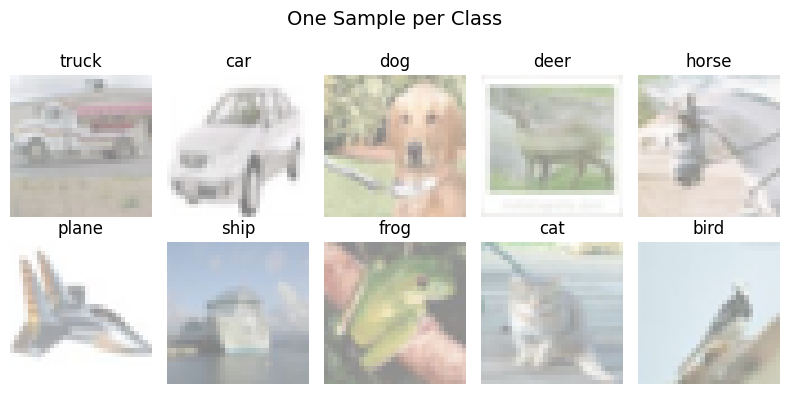

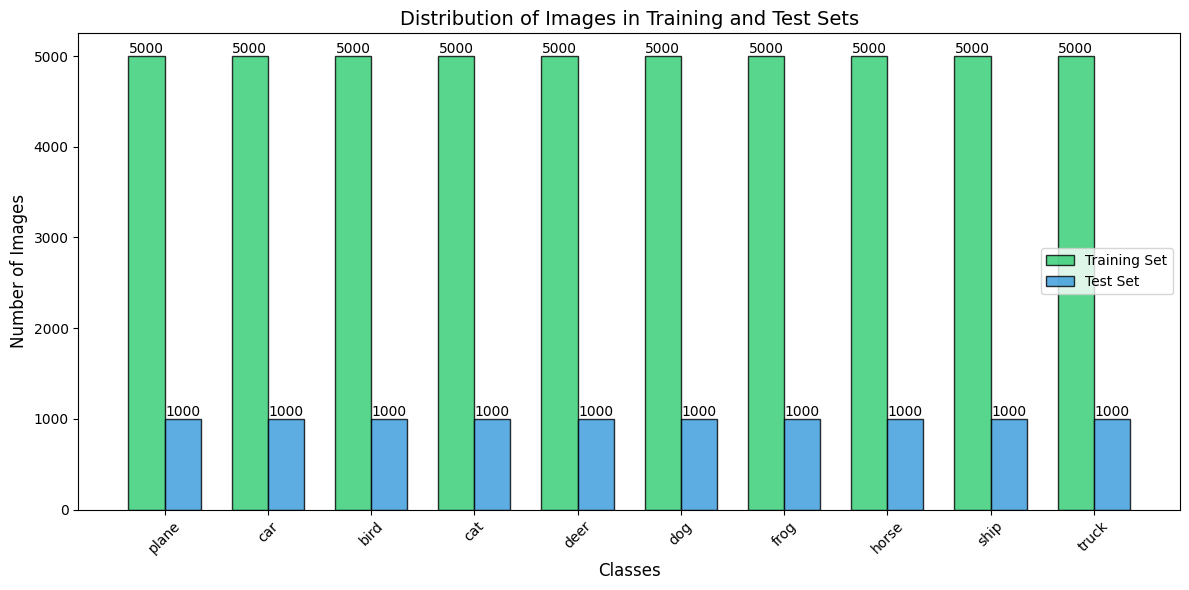

In [5]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))
plt.figure(figsize=(8,4))
class_samples = {}

# Get one image per class
for images, labels in trainloader:
    for img, label in zip(images, labels):
        label_name = classes[label]
        if label_name not in class_samples and len(class_samples) < 10:
            class_samples[label_name] = img
    if len(class_samples) == 10:
        break

# Plot one image per class
for idx, (class_name, img) in enumerate(class_samples.items(), 1):
    plt.subplot(2, 5, idx)
    img = img.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # unnormalize
    plt.imshow(img)
    plt.title(f'{class_name}')
    plt.axis('off')

plt.suptitle('One Sample per Class', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()


# Count instances in training set
train_dist = [0] * 10
for _, labels in trainloader:
    for label in labels:
        train_dist[label.item()] += 1
        
# Count instances in test set
test_dist = [0] * 10
for _, labels in testloader:
    for label in labels:
        test_dist[label.item()] += 1

# Plot histogram
plt.figure(figsize=(12, 6))
x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, train_dist, width, label='Training Set', 
        color='#2ecc71', alpha=0.8, edgecolor='black')
plt.bar(x + width/2, test_dist, width, label='Test Set',
        color='#3498db', alpha=0.8, edgecolor='black')

plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images in Training and Test Sets', fontsize=14)
plt.xticks(x, classes, rotation=45)
plt.legend()

# Add value labels on top of each bar
for i in range(len(x)):
    plt.text(x[i] - width/2, train_dist[i], str(train_dist[i]), 
             ha='center', va='bottom')
    plt.text(x[i] + width/2, test_dist[i], str(test_dist[i]), 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Q3

i. The type is normally PIL.Image
ii. to convert in a suitable type we have to do this toTensor()


In [6]:
print(f"Image shape: {images[0].shape}")
print(f"Label: {labels[0]}")

Image shape: torch.Size([3, 32, 32])
Label: 3


iii. the dimension should be (3,3,32)

iv. the meaning are > Cin = 3 are numbers of channels, 32 = Height, 32=Width

# Q4

Same as before


# Q5

In [7]:
dataset_validation, dataset_test = torch.utils.data.random_split(dataset_test, [0.5, 0.5])
validloader = DataLoader(dataset_validation, batch_size=len(dataset_validation))
testloader = DataLoader(dataset_test, batch_size=len(dataset_test))


# Q6

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from math import floor

def out_dimensions(conv_layer, h_in, w_in):
    """Calculate output dimensions after convolution"""
    h_out = floor((h_in + 2 * conv_layer.padding[0] - 
                   conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) / 
                   conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - 
                   conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) / 
                   conv_layer.stride[1] + 1)
    return h_out, w_out

# You can start by modifyng what we have done in class, or define your model from scratch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) # Is in_channels = 1 what you want? No 3 like RGB
        h_out, w_out = out_dimensions(self.conv1, 32, 32) # Is 28 what you want? no, 32 like W and H
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=1) 
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        # You can double this block! 
        self.fc1 = nn.Linear(32 * h_out * w_out, 10) # What does 32 represent? the input channel coming from the previous block
                                                    #but if we use a MaxPool layer 2x2 before, then the input channel is 16
        # You can add one fully connected layer. What do you have to change?
        self.dimensions_final = (32, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        return x

class CCNSuperSayan(nn.Module):
    def __init__(self):
        super(CCNSuperSayan, self).__init__()
        
        # First convolutional block: Conv - Conv - Activ - Pool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        
        # Second convolutional block: Conv - Conv - Activ - Pool
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, stride=1)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        
        self.pool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out/2), int(w_out/2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * h_out * w_out, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Store final dimensions for reshape in forward pass
        self.dimensions_final = (64, h_out, w_out)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool2(x)

        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
   


# Q7

In [9]:
model = CCNSuperSayan() # CNN()
learning_rate = 0.032
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)


Working on mps


In [10]:
n_epochs = 4
train_loss_list = []
validation_loss_list = []
for epoch in range(n_epochs):
    loss_train = 0
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
    loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)
    

Epoch 1: Train loss: 2.30586649100901, Validation loss 2.3080289363861084
Epoch 2: Train loss: 2.3069329481436056, Validation loss 2.3065245151519775
Epoch 3: Train loss: 2.3074195551246843, Validation loss 2.3058695793151855
Epoch 4: Train loss: 2.306848088823979, Validation loss 2.3039281368255615


In [11]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 10.04 %


# Q8

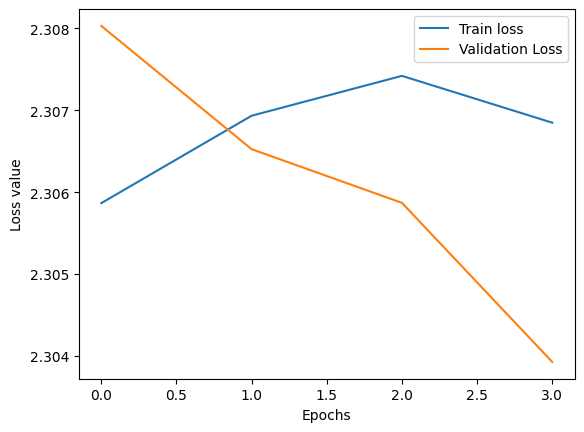

In [12]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

# Q9

In [13]:
class CCNSuperSayanGod(nn.Module):
    def __init__(self):
        super(CCNSuperSayanGod, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        h_out, w_out = out_dimensions(self.conv1, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        h_out, w_out = out_dimensions(self.conv2, h_out, w_out)
        self.pool1 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out / 2), int(w_out / 2)

        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        h_out, w_out = out_dimensions(self.conv3, h_out, w_out)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1)
        self.bn4 = nn.BatchNorm2d(128)
        h_out, w_out = out_dimensions(self.conv4, h_out, w_out)
        self.pool2 = nn.MaxPool2d(2, 2)
        h_out, w_out = int(h_out / 2), int(w_out / 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * h_out * w_out, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 10)
        
        # Store final dimensions for reshape
        self.dimensions_final = (128, h_out, w_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.gelu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.gelu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.gelu(x)
        x = self.pool2(x)

        n_channels, h, w = self.dimensions_final
        x = x.view(-1, n_channels * h * w)
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [14]:
model = CCNSuperSayanGod()
learning_rate = 0.0301
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95) #, weight_decay=1e-5)
early_stop = EarlyStopping(patience=5)
loss_fn = nn.CrossEntropyLoss()



In [ ]:
EVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' 
    if torch.backends.mps.is_available() else 'cpu')
model = model.to(DEVICE)
print("Working on", DEVICE)

train_loss_list = []
validation_loss_list = []
n_epochs = 7 

for epoch in range(n_epochs):
    loss_train = 0
    for data, target in trainloader:
        # Set the model in training mode
        model.train()
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Set the gradient to 0
        optimizer.zero_grad()
        # Make a prediction
        output = model(data)
        # Compute the loss function
        loss = loss_fn(output, target)
        loss_train += loss.item()
        # Backpropagation
        loss.backward()
        # Update parameters
        optimizer.step()
        
    loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
    train_loss_list.append(loss_train)
    
    # At the end of every epoch, check the validation loss value
    with torch.no_grad():
        model.eval()
        for data, target in validloader: # Just one batch
            data, target = data.to(DEVICE), target.to(DEVICE)
            # Make a prediction
            output = model(data)
            # Compute the loss function
            validation_loss = loss_fn(output, target).item()
            print(f"Epoch {epoch + 1}: Train loss: {loss_train}, Validation loss {validation_loss}")
            validation_loss_list.append(validation_loss)
            
    # Early stopping check
    if early_stop(model, validation_loss):
        print(f"Stopped trained at Epoch {epoch}")
        break


Working on mps


In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")


ValueError: x and y must have same first dimension, but have shapes (7,) and (1099,)

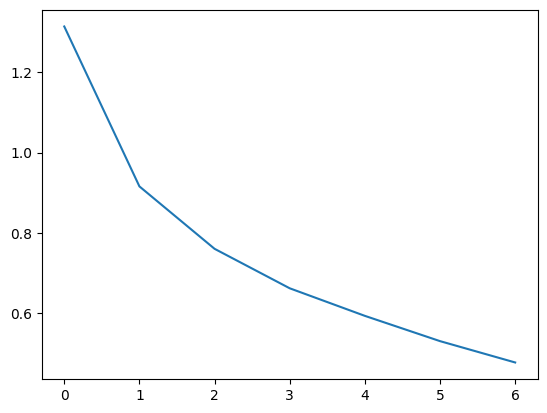

In [26]:
plt.figure()
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Train loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()